In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [2]:
X1 = np.load('Atrial_Fibrillation_ECG_signal_1780_patients_X.npy')
y_data_1 = np.load('Atrial_Fibrillation_ECG_signal_1780_patients_y_data_1.npy')
X2 = np.load('NORMAL_ECG_signal_5000_patients_X.npy')
y_data_0 = np.load('NORMAL_ECG_signal_5000_patients_y_data_0.npy')

In [3]:
X = np.concatenate((X1,X2),axis=0)
y_data = np.concatenate((y_data_1,y_data_0),axis=0)

In [4]:
y_data.shape

(6780,)

In [5]:
# X, y_data = shuffle(X, y_data, random_state=42)

In [6]:
xnew = []
ynew = []
patient_ids = []
window_size = 2500  

for i in range(X.shape[0]):
    for j in range(2):  
        start = j * window_size
        end = (j + 1) * window_size
        xnew.append(X[i, :, start:end])
        ynew.append(y_data[i]) 
        patient_ids.append(i)

xnew = np.array(xnew)
ynew = np.array(ynew)
patient_ids = np.array(patient_ids)

In [7]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV

In [8]:
# rocket=Rocket()
rocket=Rocket(num_kernels=2000)
rocket.fit(xnew)
xt=rocket.transform(xnew)

xt2 = xt
ynew2 = ynew
patient_ids2 = patient_ids

In [9]:
# np.save('xt_1798+5000_windowed5_2000_kernels_not_random.npy', xt2)
# np.save('ynew_1798+5000_windowed5_2000_kernels_not_random.npy', ynew2)
# np.save('patient_ids_1798+5000_windowed5_2000_kernels_not_random.npy', patient_ids2)

In [10]:
# xt = np.load('xt_1798+5000_windowed5_2000_kernels_not_random.npy')
# ynew = np.load('ynew_1798+5000_windowed5_2000_kernels_not_random.npy')
# patient_ids = np.load('patient_ids_1798+5000_windowed5_2000_kernels_not_random.npy')

In [11]:
xt, ynew, patient_ids = shuffle(xt2, ynew2, patient_ids2, random_state=42)

In [12]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDClassifier
import numpy as np

gkf = GroupKFold(n_splits=5)

sum_accuracy = 0
sum_sensitivity = 0
sum_specificity = 0
sum_f1 = 0

for train_idx, test_idx in gkf.split(xt, ynew, groups=patient_ids):
    X_train, X_test = xt.iloc[train_idx], xt.iloc[test_idx]
    y_train, y_test = ynew[train_idx], ynew[test_idx]

    classifier = SGDClassifier()
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    y_pred_majority = []
    for patient_idx in np.unique(patient_ids[test_idx]):
        segment_predictions = y_pred[patient_ids[test_idx] == patient_idx]
        majority_vote = np.bincount(segment_predictions).argmax()
        y_pred_majority.append(majority_vote)

    y_test_majority = []
    for patient_idx in np.unique(patient_ids[test_idx]):
        segment_predictions = y_test[patient_ids[test_idx] == patient_idx]
        majority_vote = np.bincount(segment_predictions).argmax()
        y_test_majority.append(majority_vote)

    accuracy = accuracy_score(y_test_majority, y_pred_majority)
    sum_accuracy += accuracy

    tn, fp, fn, tp = confusion_matrix(y_test_majority, y_pred_majority).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sum_sensitivity += sensitivity
    sum_specificity += specificity

    print(confusion_matrix(y_test_majority, y_pred_majority))
    print("Accuracy:", accuracy)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

average_accuracy = sum_accuracy / 5
average_sensitivity = sum_sensitivity / 5
average_specificity = sum_specificity / 5

print("Average Accuracy:", average_accuracy)
print("Average Sensitivity:", average_sensitivity)
print("Average Specificity:", average_specificity)



[[957  44]
 [  0 355]]
Accuracy: 0.967551622418879
Sensitivity: 1.0
Specificity: 0.9560439560439561
[[997   3]
 [ 34 322]]
Accuracy: 0.9727138643067846
Sensitivity: 0.9044943820224719
Specificity: 0.997
[[997   3]
 [ 33 323]]
Accuracy: 0.9734513274336283
Sensitivity: 0.9073033707865169
Specificity: 0.997
[[995   5]
 [ 20 336]]
Accuracy: 0.9815634218289085
Sensitivity: 0.9438202247191011
Specificity: 0.995
[[998   1]
 [ 50 307]]
Accuracy: 0.9623893805309734
Sensitivity: 0.8599439775910365
Specificity: 0.998998998998999
Average Accuracy: 0.9715339233038348
Average Sensitivity: 0.9231123910238253
Average Specificity: 0.9888085910085911


In [18]:
window = 5
unhealthy = 1780
folds = 4

unhealthy_x = xt2[:unhealthy*window]
healthy_x = xt2[unhealthy*window:]
unhealthy_y = ynew2[:unhealthy*window]
healthy_y = ynew2[unhealthy*window:]

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDClassifier
import numpy as np

gkf1 = GroupKFold(n_splits=folds)
gkf2 = GroupKFold(n_splits=folds)

sum_accuracy = 0
sum_f1 = 0

for train_idx1, test_idx1 in gkf1.split(xt2[:unhealthy*window], ynew2[:unhealthy*window], groups=patient_ids2[:unhealthy*window]):
    sum_accuracy = 0
    X_train1, X_test1 = xt2.iloc[train_idx1], xt2.iloc[test_idx1]
    y_train1, y_test1 = ynew2[train_idx1], ynew2[test_idx1]

    for train_idx2, test_idx2 in gkf2.split(xt2[unhealthy*window:], ynew2[unhealthy*window:], groups=patient_ids2[unhealthy*window:]):
        X_train2, X_test2 = healthy_x.iloc[train_idx2], healthy_x.iloc[test_idx2]
        y_train2, y_test2 = healthy_y[train_idx2], healthy_y[test_idx2]

        X_train = np.concatenate((X_train1, X_train2), axis=0) 
        X_test = np.concatenate((X_test1, X_test2), axis=0) 

        y_train = np.concatenate((y_train1, y_train2), axis=0) 
        y_test = np.concatenate((y_test1, y_test2), axis=0)
        
        classifier = SGDClassifier()
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        
        y_pred_majority = []
        for i in range(0, y_pred.shape[0], window):
            majority_vote = np.bincount(y_pred[i:i+window]).argmax()
            y_pred_majority.append(majority_vote)

        y_test_majority = []
        for i in range(0, y_test.shape[0], window):
            majority_vote = np.bincount(y_test[i:i+window]).argmax()
            y_test_majority.append(majority_vote)

    accuracy = accuracy_score(y_test_majority, y_pred_majority)
    sum_accuracy += accuracy

    tn, fp, fn, tp = confusion_matrix(y_test_majority, y_pred_majority).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    sum_sensitivity += sensitivity
    sum_specificity += specificity

    print(confusion_matrix(y_test_majority, y_pred_majority))
    print("Accuracy:", accuracy)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

average_accuracy = sum_accuracy / 5
average_sensitivity = sum_sensitivity / 5
average_specificity = sum_specificity / 5

print("Average Accuracy:", average_accuracy)
print("Average Sensitivity:", average_sensitivity)
print("Average Specificity:", average_specificity)

[[500   0]
 [  0 178]]
Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0


KeyboardInterrupt: 

In [15]:
# window = 8
# unhealthy = 460
# folds = 3

# unhealthy_x = xt[:unhealthy*window]
# healthy_x = xt[unhealthy*window:]
# unhealthy_y = ynew[:unhealthy*window]
# healthy_y = ynew[unhealthy*window:]

# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# from sklearn.model_selection import GroupKFold
# from sklearn.linear_model import SGDClassifier
# import numpy as np

# gkf1 = GroupKFold(n_splits=folds)
# gkf2 = GroupKFold(n_splits=folds)

# sum_accuracy = 0
# sum_sensitivity = 0
# sum_specificity = 0
# sum_f1 = 0

# # for train_idx1, test_idx1,train_idx2, test_idx2  in gkf1.split(xt[:800*5], ynew[:800*5], groups=patient_ids[:800*5]),gkf2.split(xt[800*5:], ynew[800*5:], groups=patient_ids[800*5:]):
# for train_idx1, test_idx1  in gkf1.split(xt[:unhealthy*window], ynew[:unhealthy*window], groups=patient_ids[:unhealthy*window]):
#     sum_accuracy = 0
#     X_train1, X_test1 = xt.iloc[train_idx1], xt.iloc[test_idx1]
#     y_train1, y_test1 = ynew[train_idx1], ynew[test_idx1]

#     for train_idx2, test_idx2  in gkf2.split(xt[unhealthy*window:], ynew[unhealthy*window:], groups=patient_ids[unhealthy*window:]):
#         X_train2, X_test2 = healthy_x.iloc[train_idx2], healthy_x.iloc[test_idx2]
#         y_train2, y_test2 = healthy_y[train_idx2], healthy_y[test_idx2]

#         X_train = np.concatenate((X_train1, X_train2), axis=0) 
#         X_test = np.concatenate((X_test1, X_test2), axis=0) 

#         y_train = np.concatenate((y_train1, y_train2), axis=0) 
#         y_test = np.concatenate((y_test1, y_test2), axis=0)
        
#     # for train_idx, test_idx in gkf.split(xt, ynew, groups=patient_ids):
#     #     X_train, X_test = xt.iloc[train_idx], xt.iloc[test_idx]
#     #     y_train, y_test = ynew[train_idx], ynew[test_idx]

#         classifier = SGDClassifier()
#         classifier.fit(X_train, y_train)

#         y_pred = classifier.predict(X_test)
        
#         y_pred_majority = []
#         for i in range(0, y_pred.shape[0], window):
#             majority_vote = np.bincount(y_pred[i:i+window]).argmax()
#             y_pred_majority.append(majority_vote)

#         y_test_majority = []
#         for i in range(0, y_test.shape[0], window):
#             majority_vote = np.bincount(y_test[i:i+window]).argmax()
#             y_test_majority.append(majority_vote)

#         accuracy = accuracy_score(y_test_majority, y_pred_majority)
#         sum_accuracy += accuracy

#     #     tn, fp, fn, tp = confusion_matrix(y_test_majority, y_pred_majority).ravel()

#     #     sensitivity = tp / (tp + fn)
#     #     specificity = tn / (tn + fp)
#     #     f1 = f1_score(y_test_majority, y_pred_majority)

#     #     sum_sensitivity += sensitivity
#     #     sum_specificity += specificity
#     #     sum_f1 += f1

#         print(confusion_matrix(y_test_majority, y_pred_majority))
#         print("Accuracy:", accuracy)
#     #     print("Sensitivity:", sensitivity)
#     #     print("Specificity:", specificity)
#     #     print("F1-Score:", f1)
#     #     print()

#     average_accuracy = sum_accuracy / folds
#     # average_sensitivity = sum_sensitivity / 5
#     # average_specificity = sum_specificity / 5
#     # average_f1 = sum_f1 / 5

#     print("Average Accuracy:", average_accuracy)
#     # print("Average Sensitivity:", average_sensitivity)
#     # print("Average Specificity:", average_specificity)
#     # print("Average F1-Score:", average_f1)


In [16]:
# from sklearn.linear_model import RidgeClassifierCV
# from sktime.transformations.panel.rocket import Rocket
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import scale

# X_train, X_test, y_train, y_test = train_test_split(xt, y_data,
#                                                     test_size=0.25,
#                                                     random_state=42)

# classifier=SGDClassifier()
# classifier.fit(X_train,y_train)

# ypred=classifier.predict(X_test)

# print(confusion_matrix(y_test,ypred))
# print(accuracy_score(y_test,ypred))

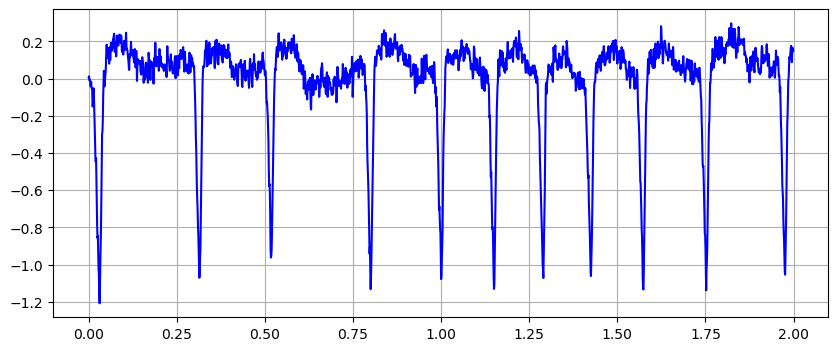

In [17]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from biosppy.signals import ecg

import wfdb
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from scipy.signal import butter, filtfilt, detrend

# record_name = files_unhealthy[0].replace("\n", "")

path = 'C:\\Users\\Pushpam\\Downloads\\'


record_name = 'JS00001'

# # Load the ECG record
# record = wfdb.rdrecord(path + record_name)

# # Extract the ECG signal
# ecg_signal = record.p_signal[:, 5] 

# # Perform baseline wander removal
# filtered_ecg = signal.detrend(ecg_signal)
# filtered_ecg=filtered_ecg[:10000]
# # Plot the ECG signal with detected R-peaks

signal, meta_val = wfdb.rdsamp(path + record_name)
value = signal.T
ecg_signals = value

filtered_ecg =X[700,3,:2000]#(detrend(ecg_signals))[2,:]

# print(filtered_ecg)
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(filtered_ecg)) / 1000, filtered_ecg, 'b')
# plt.plot(qrs_inds / record.fs, filtered_ecg[qrs_inds], 'ro', markersize=4)
plt.grid(True)
plt.show()